<a href="https://colab.research.google.com/github/DakshinDP/StockSmart---Inventory-Optimisation-Model/blob/main/Copy_of_Walmart_sales_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ujjwalchowdhury_walmartcleaned_path = kagglehub.dataset_download('ujjwalchowdhury/walmartcleaned')

print('Data source import complete.')


100%|██████████| 4.32M/4.32M [00:01<00:00, 4.52MB/s]

Extracting files...


Data source import complete.


# Importing necessary libraries


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.2 MB/s eta 0:00:00


# Loading dataset

In [ ]:
df =pd.read_csv('/content/walmart_cleaned.csv')


In [ ]:
df=df.drop(columns=['Unnamed: 0','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   IsHoliday     421570 non-null  int64  
 3   Dept          421570 non-null  float64
 4   Weekly_Sales  421570 non-null  float64
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  int64  
 10  Size          421570 non-null  int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 35.4+ MB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')


In [ ]:
df['Date'].nunique()

143

In [ ]:
df = df.set_index('Date')


# Visualizing

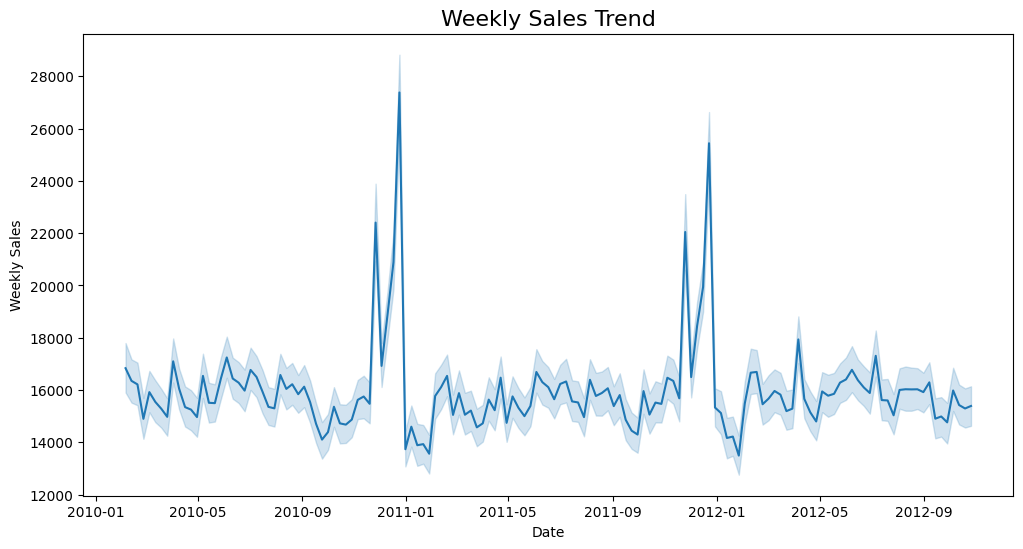

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y=df['Weekly_Sales'])
plt.title('Weekly Sales Trend', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


# Stationary  test

| Test                                         | Null Hypothesis (H₀)                        | What Low p-value Means                   | Stationary When      |
| -------------------------------------------- | ------------------------------------------- | ---------------------------------------- | -------------------- |
| **ADF (Augmented Dickey-Fuller)**            | Series is **non-stationary**                | Reject H₀ → Series **is stationary**     | **p-value < 0.05** ✅ |
| **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)** | Series is **stationary**                    | Reject H₀ → Series **is non-stationary** | **p-value > 0.05** ✅ |
| **KS (Kolmogorov–Smirnov)**                  | Both halves come from **same distribution** | Reject H₀ → Series **is non-stationary** | **p-value > 0.05** ✅ |

### Quick summary

| Test          | Stationary Condition | Non-Stationary Condition |
| ------------- | -------------------- | ------------------------ |
| **ADF Test**  | p-value < 0.05 ✅     | p-value > 0.05 ❌         |
| **KPSS Test** | p-value > 0.05 ✅     | p-value < 0.05 ❌         |
| **KS Test**   | p-value > 0.05 ✅     | p-value < 0.05 ❌         |


# KS test
"The KS test shows a p-value much smaller than 0.05, so we reject the null hypothesis. This indicates that the data does not follow the tested distribution."

In [ ]:

def ks_test_stationarity(series):
    split=len(series)//2
    series_first_half = series[:split:]
    series_second_half = series[split:]
    stat, p_value = ks_2samp(series_first_half,series_second_half)
    return stat, p_value

In [ ]:
stat , pvalue = ks_test_stationarity(df['Weekly_Sales'])

In [ ]:
print("Stat is : ",stat )
print("Pvalue is : ",pvalue )

Stat is :  0.01040871029722229
Pvalue is :  2.3987673385343967e-10


In [ ]:
pvalue>0.05

np.False_

# ADF test

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test function
def adf_test(series):
    stat, p, _, _, crit_values, _ = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {stat}, p-value: {p}")
    if p < 0.05:
        print("Conclusion: Stationary")
    else:
        print("Conclusion: Non-stationary")
    return stat, p

# KPSS Test function
def kpss_test(series):
    stat, p, _, crit_values = kpss(series, regression='c', nlags="auto")
    print(f"KPSS Statistic: {stat}, p-value: {p}")
    if p < 0.05:
        print("Conclusion: Non-stationary")
    else:
        print("Conclusion: Stationary")
    return stat, p




In [ ]:
sample_series = df['Weekly_Sales'][::10]
adf_test(sample_series)

ADF Statistic: -32.20035291860662, p-value: 0.0
Conclusion: Stationary


(np.float64(-32.20035291860662), 0.0)

# kpss test

In [ ]:
kpss_test(df['Weekly_Sales'])

KPSS Statistic: 0.2034139416318028, p-value: 0.1
Conclusion: Stationary


(np.float64(0.2034139416318028), np.float64(0.1))

# Choosing arima Parameter

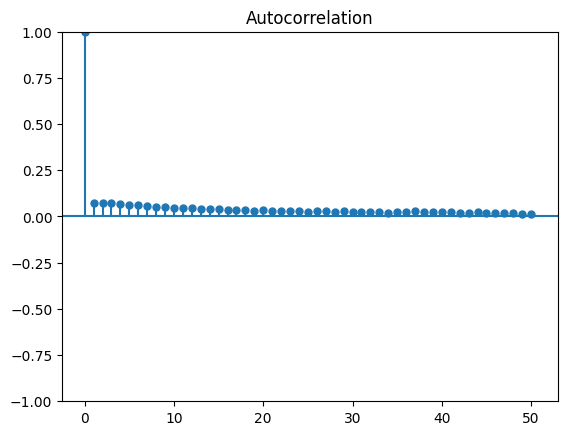

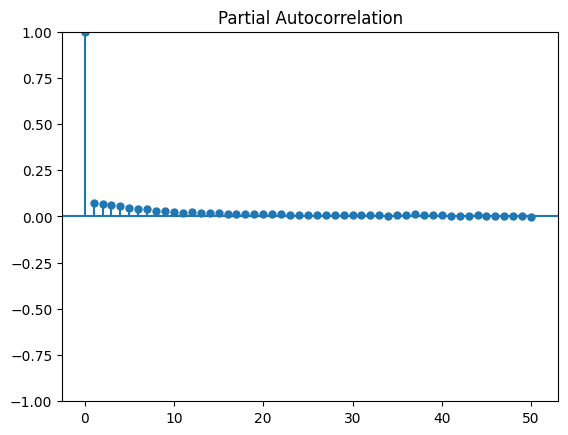

In [ ]:
plot_acf(df['Weekly_Sales'], lags=50)
plot_pacf(df['Weekly_Sales'], lags=50)
plt.show()


# Making arima model
as per our arima model our forcasting is not perfect , because we have the data related to the weekly sales since our data is seasional we can not fit it into arima model. That's why our forecasting is too poor.

In [ ]:
model = ARIMA(df['Weekly_Sales'], order=(1, 0, 1))  # replace p and q from plots
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:               421570
Model:                 ARIMA(1, 0, 1)   Log Likelihood            -4820801.590
Date:                Fri, 27 Feb 2026   AIC                        9641611.180
Time:                        12:28:21   BIC                        9641654.987
Sample:                             0   HQIC                       9641623.670
                             - 421570                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.598e+04     83.682    190.976      0.000    1.58e+04    1.61e+04
ar.L1          0.9632      0.001   1035.880      0.000       0.961       0.965
ma.L1         -0.9174      0.001   -664.730      0.0

# Forecasting

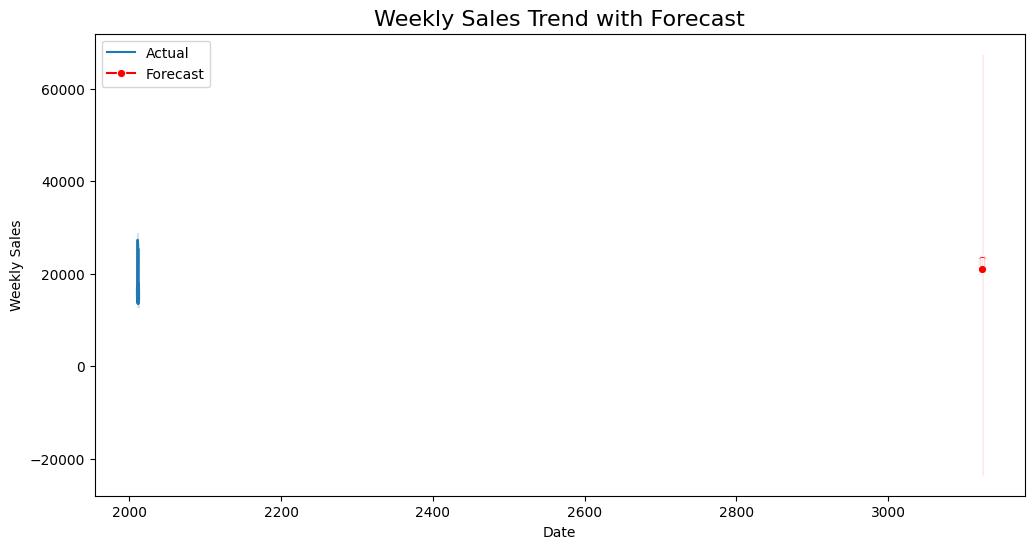

In [ ]:


# Forecast next 10 periods
forecast = model_fit.get_forecast(steps=10)
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure(figsize=(12,6))

# Original series
sns.lineplot(x=df.index, y=df['Weekly_Sales'], label='Actual')

# Forecasted series
sns.lineplot(x=predicted_values.index, y=predicted_values, label='Forecast', color='red', marker='o')

# Confidence interval as shaded area
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='pink', alpha=0.3)

plt.title('Weekly Sales Trend with Forecast', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


# Using pmdarima
Since, this model took too time to fit thats why i am not using it

In [ ]:
# from pmdarima import auto_arima
# # Assuming weekly data

# # Automatically find the best ARIMA/SARIMA model
# auto_model = auto_arima(df['Weekly_Sales'],
#                         seasonal=True, m=52,   # weekly seasonality
#                         stepwise=True,          # speeds up search
#                         suppress_warnings=True)

# print(auto_model.summary())

In [ ]:

# Reset index if Date is the index
# plot_df = df.reset_index()[['Date', 'Weekly_Sales']].copy()

# # Forecast next 20 periods
# forecast_values, conf_int = auto_model.predict(n_periods=20, return_conf_int=True)

# # Forecast index starting after last date
# last_date = plot_df['Date'].iloc[-1]
# forecast_index = pd.date_range(start=last_date + pd.Timedelta(weeks=1),
#                                periods=20, freq='W')

# # Forecast DataFrame
# forecast_df = pd.DataFrame({'Date': forecast_index, 'Weekly_Sales': forecast_values})

# # Plot
# plt.figure(figsize=(12,6))
# sns.lineplot(x='Date', y='Weekly_Sales', data=plot_df, label='Actual', color='blue', marker='o')
# sns.lineplot(x='Date', y='Weekly_Sales', data=forecast_df, label='Forecast', color='red', marker='o')
# plt.title('Weekly Sales Trend + Forecast', fontsize=16)
# plt.xlabel('Date')
# plt.ylabel('Weekly Sales')
# plt.legend()
# plt.show()
